In [1]:
from dotenv import load_dotenv
import os, sys

sys.path.append(os.path.join(os.getcwd(), '..', '..'))

load_dotenv()

True

# Retriever Tool
- Chroma와 `sentence-transformers/all-MiniLM-L6-v2` 이용

In [2]:
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

vectorstore = Chroma(
    persist_directory="./chatbot_20251108",
    embedding_function=HuggingFaceEmbeddings(model_name="BAAI/bge-m3"),
)
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 5}
)

c:\Users\Lee JinSeoung\OneDrive\Desktop\4학년 1학기\캡스톤디자인\chatbot-api\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Langchain prebuilt `create_retriever_tool` 이용하여 retriever tool 생성

In [3]:
from langchain_classic.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    name="retrieve_kongju_national_university_info",
    description="Search and return information about 국립공주대학교",
    retriever=retriever,
)

- retriever_tool 테스트

In [4]:
retriever_tool.invoke({"query": "소프트웨어학과 수강과목 알려줘"})

'[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 신호 및 시스템 과목은 3학점으로 3학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 웹프로그래밍 과목은 3학점(4시간 강의)으로 3학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 모바일프로그래밍 과목은 3학점(4시간 강의)으로 3학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 시스템분석설계 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 컴퓨터비전 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 컴퓨터그래픽스 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 클라우드컴퓨팅 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 IT실무영어 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 가상현실 과목은 3학점으로 4학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 분산컴퓨팅 과목은 3학점으로 4학년 2학기에 수강한다.\n\n[소프트웨어학과 교육과정표 2020년도 입학자 적용] 핵심교양 (3학점)인 선택 과목은

- LLM에 tool로 바인딩

In [5]:
from langchain_openai import ChatOpenAI

from src.agent.state import CustomState

model = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0,
)

def generate_query_or_respond(state: CustomState):
    response = (
        model.bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [6]:
# 단순 응답 제공
input = {
    "messages": [
        {
            "role": "user",
            "content": "안녕하세요",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요? 국립공주대학교 관련 정보 검색, 학과 안내, 입학 요건, 위치/연락처 등 궁금한 내용이 있으면 말씀해 주세요. 찾고 싶은 구체적인 주제나 검색어를 알려주시면 바로 도와드리겠습니다. 필요하시면 영어 등 다른 언어로도 도와드릴게요.


In [7]:
# semantic search 결과 제공

input_with_retrieval = {
    "messages": [
        {
            "role": "user",
            "content": "소프트웨어학과 4학년 수강과목 알려줘",
        }
    ]
}
generate_query_or_respond(input_with_retrieval)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_kongju_national_university_info (call_VuafcmdIXtMipTBcewGbPtnd)
 Call ID: call_VuafcmdIXtMipTBcewGbPtnd
  Args:
    query: 국립공주대학교 소프트웨어학과 4학년 수강과목


# Document Relevancy Checker
- 검색된 문서가 질문과 연관되어 있는지 LLM 기반으로 판단

In [11]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

def grade_documents(
    state: CustomState
) -> Literal["generate", "rewrite_question"]:
    question = state["messages"][-1].content
    context = state.get("documents")

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        model.with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )

    score = response.binary_score
    return "generate" if score == "yes" else "rewrite_question"


# Human-in-the-loop
- 인간이 개입하여 작업을 명료화함

In [9]:
HITL_PROMPT = (
    "Answer the following sentence:\n\n"
    "제공하신 질문에 대한 답변을 드리기 위해 추가 정보가 필요합니다. 학과, 연도 등 세부 정보를 포함하여 질문을 구체적으로 작성해 주세요.\n\n"
    "Answer in {language}. If 'ko', use Korean. If 'en', use English."
    "Do not answer anything else."
)

def rewrite_question(state: CustomState):
    language = state.get("language", "ko")
    prompt = HITL_PROMPT.format(language=language)
    response = model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

# Build Graph
- 구현한 tool과 node를 이용하여 그래프 연결

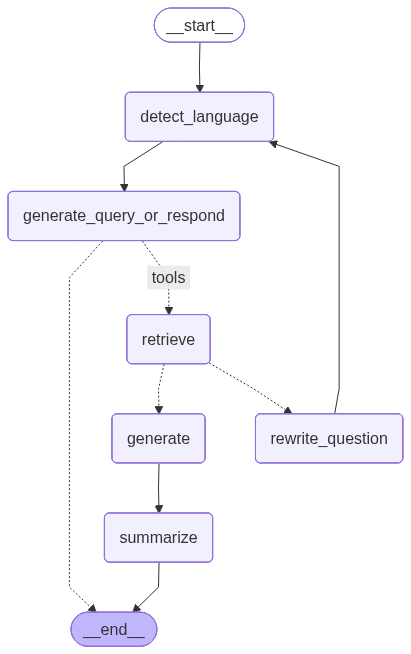

In [33]:
from src.agent.nodes import language_detection_node, generation_node, summarization_node
from src.agent.graph import visualize_graph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver  

checkpointer = InMemorySaver()
builder = StateGraph(CustomState)

builder.add_node("detect_language", language_detection_node)
builder.add_node(generate_query_or_respond)
builder.add_node("retrieve", ToolNode([retriever_tool]))
builder.add_node("rewrite_question", rewrite_question)
builder.add_node("generate", generation_node)
builder.add_node("summarize", summarization_node)

builder.add_edge(START, "detect_language")
builder.add_edge("detect_language", "generate_query_or_respond")
builder.add_conditional_edges(
    "generate_query_or_respond",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    }
)
builder.add_conditional_edges(
    "retrieve",
    grade_documents,
)
builder.add_edge("generate", "summarize")
builder.add_edge("rewrite_question", "detect_language")
builder.add_edge("summarize", END)

graph = builder.compile(checkpointer=checkpointer)
visualize_graph(graph)

- 그래프 실행

In [36]:
from langchain_core.runnables import RunnableConfig

config: RunnableConfig = {
    "configurable": {
        "thread_id": 123 
    }
}

query = {
    "messages": [
        {
            "role": "user",
            "content": "소프트웨어학과 4학년 수강과목 알려줘",
        }
    ]
}

for chunk in graph.stream(query, config=config):
    for node, output in chunk.items():
        print(f"Node: {node}")
        if "messages" in output and output["messages"]:
            output["messages"][-1].pretty_print()

Node: detect_language
Node: generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_kongju_national_university_info (call_Zp7LFZw0zKlSPDKEjHSJSQjy)
 Call ID: call_Zp7LFZw0zKlSPDKEjHSJSQjy
  Args:
    query: 공주대학교 소프트웨어학과 4학년 수강과목
Node: retrieve
================================= Tool Message =================================
Name: retrieve_kongju_national_university_info

수강신청은 강의나 실험·실습을 듣기 위해 자신이 이수할 교과목을 선택하여 신청하는 것이다.
5페이지
교육과정은 교양필수, 교양선택, 전공, 융합탐색 등으로 구성되어 있으며 각 항목의 학점과 비고는 다음과 같다. 교양필수의 기초교양필수는 10학점으로 공주대학교 학생들이 공통으로 이수해야 하는 교양과목이다. 교양선택에는 기초교양선택 14학점이 포함되며 이는 소프트웨어학과 학생들이 수강해야 하는 교양과목이고, 균형교양선택은 12학점으로 공과대학 학생들이 수강해야 하는 교양과목이다. 소양교양필수는 0학점으로 우리 학과 학생은 수강해서는 안 된다. 전공에서는 전공기초가 63학점으로 소프트웨어학과 학생들이 필수로 이수해야 하는 과목들이며, 전공핵심은 18학점 이상으로 소프트웨어학과 학생들이 수강해야 하는 전공과목이다. 융합탐색은 1~13학점 범위의 타학과 전공과목이다. 졸업학점 합계는 최소 130학점으로 졸업을 위한 기준이다.
6페이지
4. 수강신청하기
가. 수강신청 일정 안내  
자세한 내용은 공주대학교 홈페이지 정보광장 공지사항(https://www.kongju.ac.kr/bbs/

In [37]:
query_2 = {
    "messages": [
        {
            "role": "user",
            "content": "2025년 정보를 원해",
        }
    ]
}

for chunk in graph.stream(query_2, config=config):
    for node, output in chunk.items():
        print(f"Node: {node}")
        if "messages" in output and output["messages"]:
            output["messages"][-1].pretty_print()

Node: detect_language
Node: generate_query_or_respond
================================== Ai Message ==================================

다음은 2025학년도 입학자 적용 교육과정에 따른 4학년 수강과목 정리입니다. 과목명은 학과 공지나 시기에 따라 변경될 수 있으니 최종 수강신청 전 학과 공지와 포털의 개설강좌 목록을 확인해 주세요.

1) 4학년 1학기
- 정보보안 과목 (전공, 3학점)
  - 4학년 1학기에 수강하는 전공 기초/전공 핵심 범주의 보안 관련 과목으로 기재되어 있습니다.
- 미래설계Ⅴ (전공 기초, 0학점)
  - 4학년 1학기에 수강하는 0학점 과목으로, 학점 인정은 없지만 이수해야 할 항목으로 명시됩니다.

2) 4학년 2학기
- 캡스톤디자인프로젝트Ⅱ (전공, 3학점)
  - 팀 단위 프로젝트를 포함하는 capstone 디자인의 2학기 차수 과목으로 수강합니다.
- 미래설계Ⅵ (전공 기초, 0학점)
  - 4학년 2학기에 수강하는 0학점 과목으로 이수는 하지만 학점은 부여되지 않습니다.

참고 및 학습 맥락
- 4학년은 오픈소스 커뮤니티 참여 및 협업/프로젝트 관리 역량 강화에 초점을 둡니다.
- 오픈소스 도구/플랫폼 예시(4학년 기준):
  - 도구: Linux, Android
  - 오픈소스 SW/프레임워크: Spring Framework, Kubernetes, NLTK, Luminoth
  - 협업·프로젝트 관리에 필요한 역량 강화
- 수강신청 및 구체적 과목명 확인 방법
  - 수강신청 페이지: http://sugang.kongju.ac.kr
  - 학과 공지 및 정보광장: 공주대학교 홈페이지의 정보광장 공지사항이나 학과 공지
  - 실제 개설강좌 목록은 매 학기 다르게 운영될 수 있으므로 반드시 최종 공지 확인

원하시면 2025학년도 4학년의 exact 개설강좌 코드/과목명 리스트를 학과 공지에서 확인한 뒤 정리해 드리겠습